In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Chargement de la base de donnée
acc_df = pd.read_csv(r'C:\Users\RiL\Desktop\Prog\scoring_ifrs9\data\raw\data_final.csv', low_memory=False)
acc_df.head()

,Unnamed: 0,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,tot_cur_bal,open_acc_6m,total_bal_il,inq_fi,mort_acc,num_sats,out_prncp,total_pymnt,recoveries
0,0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Fully Paid,5.91,144904.0,2.0,4981.0,3.0,1.0,7.0,0.0,4421.723917,0.0
1,1,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Fully Paid,16.06,204396.0,1.0,18005.0,0.0,4.0,22.0,0.0,25679.660000,0.0
2,2,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Fully Paid,10.78,189699.0,0.0,10827.0,2.0,5.0,6.0,0.0,22705.924294,0.0
3,3,60 months,22.45,289.91,F,3 years,MORTGAGE,110000.0,Fully Paid,25.37,331730.0,1.0,73839.0,0.0,6.0,12.0,0.0,11740.500000,0.0
4,4,36 months,13.44,405.18,C,4 years,RENT,104433.0,Fully Paid,10.20,12798.0,0.0,3976.0,2.0,0.0,5.0,0.0,13708.948530,0.0


In [4]:
var_d_interet = [
    "term", "int_rate", "installment", "grade", "emp_length", "home_ownership", "annual_inc", "loan_status", "dti", "tot_cur_bal", "open_acc_6m",
    "total_bal_il", "inq_fi", "mort_acc", "num_sats"       
]
acc_df = acc_df[var_d_interet]
print(acc_df.shape)
acc_df.head()

(1345310, 15)


,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,tot_cur_bal,open_acc_6m,total_bal_il,inq_fi,mort_acc,num_sats
0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Fully Paid,5.91,144904.0,2.0,4981.0,3.0,1.0,7.0
1,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Fully Paid,16.06,204396.0,1.0,18005.0,0.0,4.0,22.0
2,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Fully Paid,10.78,189699.0,0.0,10827.0,2.0,5.0,6.0
3,60 months,22.45,289.91,F,3 years,MORTGAGE,110000.0,Fully Paid,25.37,331730.0,1.0,73839.0,0.0,6.0,12.0
4,36 months,13.44,405.18,C,4 years,RENT,104433.0,Fully Paid,10.20,12798.0,0.0,3976.0,2.0,0.0,5.0


In [8]:
acc_df['mort_acc'].value_counts()

mort_acc
0.0     523837
1.0     226135
2.0     188941
3.0     139381
4.0      94920
5.0      57632
6.0      32539
7.0      16850
8.0       8378
9.0       4285
10.0      2197
11.0      1206
12.0       640
13.0       356
14.0       244
15.0       132
16.0        93
17.0        61
18.0        48
19.0        29
20.0        25
24.0        16
21.0        14
22.0        14
23.0        10
25.0         9
27.0         8
26.0         6
29.0         4
28.0         4
34.0         3
37.0         2
31.0         2
30.0         2
32.0         2
47.0         1
35.0         1
51.0         1
36.0         1
Name: count, dtype: int64

In [5]:
acc_df.isna().sum()

term                   0
int_rate               0
installment            0
grade                  0
emp_length         78511
home_ownership         0
annual_inc            14
loan_status            0
dti                  374
tot_cur_bal        67527
open_acc_6m       807713
total_bal_il      807712
inq_fi            628048
mort_acc           47281
num_sats           55841
dtype: int64

In [5]:
print(acc_df.shape)
acc_df.info()

(1345310, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 18 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   term            1345310 non-null  object 
 1   int_rate        1345310 non-null  float64
 2   installment     1345310 non-null  float64
 3   grade           1345310 non-null  object 
 4   emp_length      1266799 non-null  object 
 5   home_ownership  1345310 non-null  object 
 6   annual_inc      1345296 non-null  float64
 7   loan_status     1345310 non-null  object 
 8   dti             1344936 non-null  float64
 9   tot_cur_bal     1277783 non-null  float64
 10  open_acc_6m     537597 non-null   float64
 11  total_bal_il    537598 non-null   float64
 12  inq_fi          717262 non-null   float64
 13  mort_acc        1298029 non-null  float64
 14  num_sats        1289469 non-null  float64
 15  out_prncp       1345310 non-null  float64
 16  total_pymnt     134531

In [6]:
# Traitement des valeurs manquantes
'''Pour les variables qui ont un taux de non-reponse inferieur a 10% on va imputer par la moyenne ou le mode'''

'Pour les variables qui ont un taux de non-reponse inferieur a 10% on va imputer par la moyenne ou le mode'

In [8]:
data_final = acc_df

In [8]:
def na_percent(data, var):
    per = round((data[var].isna().sum() / data.shape[0]) * 100, 2)
    return per

In [9]:
na_per = {col: na_percent(data_final, col) for col in var_d_interet}
col_fill = [p for p, v in na_per.items() if v <= 10 and v > 0]
col_fill.insert(1, 'annual_inc')
print(col_fill)

['emp_length', 'annual_inc', 'dti', 'tot_cur_bal', 'mort_acc', 'num_sats']


In [10]:
for i in data_final[col_fill]:
    if data_final[i].dtypes == float:
        data_final[i] = data_final[i].fillna(data_final[i].mean())
    else:
        data_final[i] = data_final[i].fillna(data_final[i].mode()[0])  

In [12]:
data_final

,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,tot_cur_bal,open_acc_6m,total_bal_il,inq_fi,mort_acc,num_sats,out_prncp,total_pymnt,recoveries
0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Fully Paid,5.91,144904.0,2.0,4981.0,3.0,1.0,7.0,0.0,4421.723917,0.0
1,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Fully Paid,16.06,204396.0,1.0,18005.0,0.0,4.0,22.0,0.0,25679.660000,0.0
2,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Fully Paid,10.78,189699.0,0.0,10827.0,2.0,5.0,6.0,0.0,22705.924294,0.0
3,60 months,22.45,289.91,F,3 years,MORTGAGE,110000.0,Fully Paid,25.37,331730.0,1.0,73839.0,0.0,6.0,12.0,0.0,11740.500000,0.0
4,36 months,13.44,405.18,C,4 years,RENT,104433.0,Fully Paid,10.20,12798.0,0.0,3976.0,2.0,0.0,5.0,0.0,13708.948530,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345305,60 months,9.49,377.95,B,5 years,OWN,150000.0,Fully Paid,20.59,168758.0,0.0,30516.0,NaN,3.0,17.0,0.0,20756.233632,0.0
1345306,60 months,13.99,683.94,C,9 years,MORTGAGE,95000.0,Fully Paid,22.03,663465.0,0.0,70652.0,NaN,3.0,16.0,0.0,35848.764532,0.0
1345307,60 months,14.49,752.74,C,3 years,MORTGAGE,54000.0,Charged Off,10.34,408701.0,2.0,11274.0,NaN,3.0,14.0,0.0,3737.940000,0.0
1345308,60 months,12.79,362.34,C,10+ years,RENT,45000.0,Fully Paid,12.25,65797.0,1.0,58097.0,NaN,0.0,12.0,0.0,18660.607569,0.0


In [13]:
data_final.isna().sum()

term                   0
int_rate               0
installment            0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
loan_status            0
dti                    0
tot_cur_bal            0
open_acc_6m       807713
total_bal_il      807712
inq_fi            628048
mort_acc               0
num_sats               0
out_prncp              0
total_pymnt            0
recoveries             0
dtype: int64

In [13]:
data_final['grade'].value_counts()

grade
B    392741
C    381686
A    235090
D    200953
E     93650
F     32058
G      9132
Name: count, dtype: int64

In [50]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors

In [34]:
# On dit à la fonction de 'regarder' la colonne 'loan_status'
# pour faire le split, afin que les deux futurs dataframes
# aient la même proportion de 'Default' et 'Paid'.
stratify_column = data_final['loan_status']
train_set, test_set = train_test_split(
    data_final,                 # <--- On split le DataFrame entier
    test_size=0.2,
    random_state=44,
    stratify=stratify_column    # <--- On stratifie en se basant sur la colonne 'y'
)

In [16]:
# --- 1. Définition des variables ---

# Variables à imputer
target_vars = ['open_acc_6m', 'total_bal_il', 'inq_fi']

# Variables auxiliaires (pour trouver les voisins)
numeric_features = ['dti', 'tot_cur_bal', 'int_rate', 'annual_inc', 'mort_acc']
categorical_features_ordinal = ['grade']
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
categorical_features_nominal = ['home_ownership']

aux_vars = numeric_features + categorical_features_ordinal + categorical_features_nominal

# --- 2. Préparation du pré-traitement ---

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_nom', OneHotEncoder(handle_unknown='ignore'), categorical_features_nominal),
        ('cat_ord', OrdinalEncoder(categories=[grade_order]), categorical_features_ordinal)
    ],
    remainder='passthrough'
)

In [36]:
# --- 4. Séparation Donneur / Receveur ---

# 'is_donor' est VRAI si la ligne est complète pour les cibles
is_donor = train_set[target_vars].notna().all(axis=1)
# 'is_recipient' est VRAI si la ligne a AU MOINS un manquant
is_recipient = ~is_donor

In [37]:
df_donor = train_set.loc[is_donor, target_vars]

In [38]:
print(df_donor.shape)
df_donor.head()

(271386, 3)


,open_acc_6m,total_bal_il,inq_fi
585684,1.0,18812.0,1.0
494752,1.0,4827.0,1.0
483876,0.0,0.0,2.0
648635,1.0,49690.0,0.0
631367,0.0,17804.0,0.0


In [39]:
aux_vars

['dti',
 'tot_cur_bal',
 'int_rate',
 'annual_inc',
 'mort_acc',
 'grade',
 'home_ownership']

In [40]:
X_trans = preprocessor.fit_transform(train_set[aux_vars])

In [43]:
X_trans[0, :]

array([ 0.62848409,  0.75103245, -1.1215736 , -0.140361  ,  0.67555976,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [44]:
X_donor = X_trans[is_donor]
X_recip = X_trans[is_recipient]

In [45]:
print(X_donor.shape) # individus repondant pour les 3 variables
X_recip.shape # individus ayant au moins une valeur manquante pour les 3 variables

(271386, 12)


(804862, 12)

In [46]:
k = 10
nn_model = NearestNeighbors(n_neighbors=k, metric='euclidean', n_jobs=-1)
nn_model.fit(X_donor)

,n_neighbors,10
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'euclidean'
,p,2
,metric_params,None
,n_jobs,-1


In [47]:
# matrice de distance et indice des 10 plus proches voisins pour chaque receveur
# 'idx' est ma matrice de (N_receveurs, 10 voisins)
dist, idx = nn_model.kneighbors(X_recip, n_neighbors=k)
print(dist.shape)
idx.shape

(804862, 10)


(804862, 10)

In [48]:
data_imp = train_set.copy()

In [49]:
data_recip_idx = data_imp.index[is_recipient]
data_recip_idx.shape

(804862,)

In [50]:
np.random.seed(44)

n_recip = len(idx)
print(n_recip)

k_neighbors = idx.shape[1]
print(k_neighbors)

random_donor_idx = np.random.randint(0, k_neighbors, size=n_recip) # generation des indices pour le hot-deck aleatoire en une seule fois
print('vecteur de valeur entre 0 et 10 permettant la selection hot deck')
print(random_donor_idx.shape)
print('choix des donneurs dans la matrice idx')
sorted_idx = np.arange(n_recip) # tout les reveveurs ordonnées en indice

donor_idx = idx[sorted_idx, random_donor_idx] # choix des donneurs pour tout les receveurs
bloc = df_donor.iloc[donor_idx]
bloc.index = data_recip_idx

# on re remplit que la valeur manquante pour un bloc specifique
for p in target_vars:
    data_imp[p] = data_imp[p].fillna(bloc[p])

804862
10
vecteur de valeur entre 0 et 10 permettant la selection hot deck
(804862,)
choix des donneurs dans la matrice idx


In [1]:
from sklearn.impute import SimpleImputer

In [9]:
stratify_column = data_final['loan_status']
train_set, test_set = train_test_split(
    data_final,                 # <--- On split le DataFrame entier
    test_size=0.2,
    random_state=44,
    stratify=stratify_column    # <--- On stratifie en se basant sur la colonne 'y'
)

In [2]:
var_d_interet = [
    "term", "int_rate", "installment", "grade", "emp_length", "home_ownership", "annual_inc", "loan_status", "dti", "tot_cur_bal", "open_acc_6m",
    "total_bal_il", "inq_fi", "mort_acc", "num_sats"      
]

In [ ]:
    'dti', 'tot_cur_bal', 'int_rate', 'annual_inc', 'mort_acc',
    'grade', 'home_ownership', 'open_acc_6m', 'total_bal_il', 'inq_fi',
    'term', 'installment', 'emp_length', 'mort_acc', 'num_sats',
    'out_prncp', 'total_pymnt', 'recoveries'
]

In [10]:
def impute_det(train_set, test_set, var):
    """
    Impute les variables déterministes (faible % de NaN)
    
    1. Apprend les valeurs (moyenne/mode) sur le train_set.
    2. Applique (transform) ces valeurs au train_set et au test_set.
    """
    train_set_imp = train_set.copy()
    test_set_imp = test_set.copy()

    per = round((train_set[var].isna().sum() / train_set.shape[0]) * 100, 2)
    na_per = {col: per[col] for col in var}
    col_fill = [p for p, v in na_per.items() if v <= 10 and v > 0]
    if 'annual_inc' not in col_fill and 'annual_inc' in train_set.columns:
        col_fill.append('annual_inc')

    num_cols = [n for n in col_fill if pd.api.types.is_numeric_dtype(train_set[n])]
    cat_cols = [ch for ch in col_fill if not pd.api.types.is_numeric_dtype(train_set[ch])]
    #  Imputation Numérique (Moyenne)
    if num_cols:
        imp_mean = SimpleImputer(strategy='mean')
        

        imp_mean.fit(train_set_imp[num_cols])
        
    
        train_set_imp[num_cols] = imp_mean.transform(train_set_imp[num_cols])
        test_set_imp[num_cols] = imp_mean.transform(test_set_imp[num_cols])

    #  Imputation Catégorielle (Mode)
    if cat_cols:
        imputer_mode = SimpleImputer(strategy='most_frequent')
        
     
        imputer_mode.fit(train_set_imp[cat_cols])
        
     
        train_set_imp[cat_cols] = imputer_mode.transform(train_set_imp[cat_cols])
        test_set_imp[cat_cols] = imputer_mode.transform(test_set_imp[cat_cols])

    return train_set_imp, test_set_imp

ModuleNotFoundError: No module named 'src'

In [17]:
# 1. Définir les chemins relatifs
# ../ signifie "remonter d'un dossier" (du dossier /notebooks au dossier racine)
train_path = r'C:\Users\RiL\Desktop\Prog\scoring_ifrs9\data\processed\test_imp.parquet'
test_path = r'C:\Users\RiL\Desktop\Prog\scoring_ifrs9\data\processed\train_imp.parquet'

# 2. Charger les fichiers
try:
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)
    
    print("Données traitées (train et test) chargées avec succès.")
    
    # 3. Vérifier le chargement
    print("\n--- Aperçu du Train Set ---")
    display(train_df.head())
    
except FileNotFoundError:
    print(f"ERREUR : Fichiers non trouvés.")
    print(f"Vérifiez que le chemin '{train_path}' est correct.")
    print("Avez-vous bien lancé le script de preprocessing avant ?")

# 
# REMARQUE :
# Si vous avez sauvegardé en .csv au lieu de .parquet,
# changez simplement la ligne par :
# train_df = pd.read_csv(train_path)
# test_df = pd.read_csv(test_path)
#

Données traitées (train et test) chargées avec succès.

--- Aperçu du Train Set ---


,Unnamed: 0,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,tot_cur_bal,open_acc_6m,total_bal_il,inq_fi,mort_acc,num_sats,out_prncp,total_pymnt,recoveries
651386,651386,36 months,7.49,435.43,A,1 year,RENT,50000.0,Fully Paid,12.72,68445.0,2.0,50143.0,1.0,0.0,25.0,0.0,15663.538747,0.0
184543,184543,36 months,12.69,848.69,C,10+ years,MORTGAGE,47000.0,Fully Paid,20.71,175433.0,0.0,9653.0,5.0,5.0,15.0,0.0,30538.268024,0.0
1009613,1009613,36 months,8.90,317.54,A,2 years,MORTGAGE,47300.0,Fully Paid,17.32,204682.0,0.0,52192.0,0.0,1.0,14.0,0.0,11374.100000,0.0
1097592,1097592,36 months,12.12,329.39,B,2 years,OWN,46814.0,Fully Paid,23.49,70049.0,2.0,35306.0,0.0,0.0,9.0,0.0,11145.593892,0.0
213331,213331,36 months,7.89,187.72,A,10+ years,MORTGAGE,32000.0,Fully Paid,15.47,208351.0,1.0,27369.0,1.0,3.0,9.0,0.0,6652.398550,0.0


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [10]:
train_df.head()

,Unnamed: 0,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,dti,tot_cur_bal,open_acc_6m,total_bal_il,inq_fi,mort_acc,num_sats,out_prncp,total_pymnt,recoveries
651386,651386,36 months,7.49,435.43,A,1 year,RENT,50000.0,Fully Paid,12.72,68445.0,2.0,50143.0,1.0,0.0,25.0,0.0,15663.538747,0.0
184543,184543,36 months,12.69,848.69,C,10+ years,MORTGAGE,47000.0,Fully Paid,20.71,175433.0,0.0,9653.0,5.0,5.0,15.0,0.0,30538.268024,0.0
1009613,1009613,36 months,8.90,317.54,A,2 years,MORTGAGE,47300.0,Fully Paid,17.32,204682.0,0.0,52192.0,0.0,1.0,14.0,0.0,11374.100000,0.0
1097592,1097592,36 months,12.12,329.39,B,2 years,OWN,46814.0,Fully Paid,23.49,70049.0,2.0,35306.0,0.0,0.0,9.0,0.0,11145.593892,0.0
213331,213331,36 months,7.89,187.72,A,10+ years,MORTGAGE,32000.0,Fully Paid,15.47,208351.0,1.0,27369.0,1.0,3.0,9.0,0.0,6652.398550,0.0


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
num_features = ["int_rate", "installment", "annual_inc","dti", "tot_cur_bal","open_acc_6m",
                "total_bal_il", "inq_fi", "mort_acc", "num_sats"]
cat_features = ["term", "grade", "emp_length", "home_ownership"]

cat_order = [
    [' 36 months', ' 60 months'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
    '6 years', '7 years', '8 years', '9 years', '10+ years'],
    ['OWN', 'MORTGAGE', 'RENT', 'ANY', 'OTHER', 'NONE']
]

In [20]:
train_df['loan_status'].values

array(['Fully Paid', 'Fully Paid', 'Fully Paid', ..., 'Fully Paid',
       'Charged Off', 'Fully Paid'], shape=(269062,), dtype=object)

In [21]:
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("ord_enc", OrdinalEncoder(categories=cat_order))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver='lbfgs'))
])

train_df['loan_status'] = train_df['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

test_df['loan_status'] = test_df['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

In [22]:
X, y = train_df.drop('loan_status', axis=1), train_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [24]:
y_proba

array([0.18775778, 0.18886827, 0.46310175, ..., 0.07714663, 0.07400485,
       0.10314349], shape=(53813,))

AUC : 0.9911
Accuracy : 0.9852
Log-loss : 0.0577

Classification report :
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     42814
           1       0.98      1.00      0.99    172436

    accuracy                           0.99    215250
   macro avg       0.99      0.97      0.98    215250
weighted avg       0.99      0.99      0.99    215250



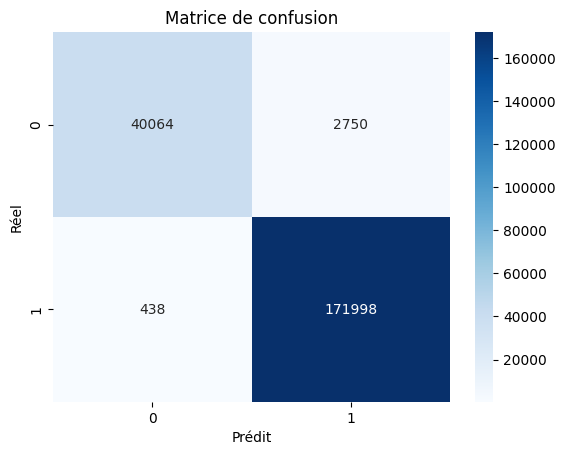

In [142]:
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_proba)

print(f"AUC : {auc:.4f}")
print(f"Accuracy : {acc:.4f}")
print(f"Log-loss : {ll:.4f}")
print("\nClassification report :\n", classification_report(y_test, y_pred))

# --- Matrice de confusion ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_pred)